----

# **Credit Scoring - Building and Running a Machine Learning model**

----

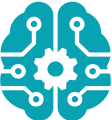

<span style='color:#09a2b3'>**Author:**</span> Bob Peulen </br>
<span style='color:#09a2b3'>**Title:**</span> Senior Cloud Specialist </br>
<span style='color:#09a2b3'>**Domain:**</span> Data Science</br></br>


---

# **Imports**

In [1]:
import oci
import uuid
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import random
from ads.model.framework.sklearn_model import SklearnModel
from ads.common.model_metadata import UseCaseType
import time

## **Authentication**

In [2]:
# Check Authentication with OCI
def oci_authenticate(debug):
    
    # Set up and read in config file to authenticate against OCI
    config = oci.config.from_file('~/.oci/config', 'DEFAULT')

    # Create a Service Client to Identity API
    identity = oci.identity.IdentityClient(config)

    # Check if successful response received
    if identity.get_user(config['user']).status == 200:
        
        # Get the current User Information from API
        user = identity.get_user(config['user']).data

        if debug == 'y':
            print('\nAuthentication Successful!')
            print('\nOCI User Logged In:', user.name)
            print('OCI User Email:', user.email)
    else:
        print('Authentication Failed!')
        print('HTTP Request Error Code:', identity.get_user(config['user']).status)

    # Return config object to be used to initialise AI Language Client
    return config

# Authenticate against OCI
config = oci_authenticate('y')


Authentication Successful!

OCI User Logged In: oracleidentitycloudservice/bob.peulen@oracle.com
OCI User Email: None


----------

# **1. Machine Learning model - Credit Score**

---

## **1.1 Read in data**

In [3]:
df_in = pd.read_excel("<path_to             /2-CreditScoring_13K.xlsx")
df_in.head()

,Customer ID,Age,Income,Marital Status,Number of Liables,Wealth,Education Level,Tenure,Loan Type,Loan Amount,...,Churn Rate of CC2,Churn Rate of CCN,Churn Rate of Account No.1,Churn Rate of Account No.2,Churn Rate of Account No.N,Health Score,Customer Depth,Lifecycle Stage,count,Loan Status
0,68,31.0,500.0,Single,2.0,Very Poor,Primary School Grad,39.0,Housing,100000.0,...,0.5,0.50,0.2,0.4,0.30,7.0,6.0,2.0,1,Submitted
1,451,45.0,500.0,Married,3.0,Very Poor,Primary School Grad,39.0,Need,45000.0,...,1.0,0.60,1.0,0.6,0.80,6.0,1.0,3.0,1,Approved
2,535,20.0,500.0,Married,3.0,Very Poor,Primary School Grad,7.0,Need,30000.0,...,0.5,0.55,0.5,0.4,0.45,8.0,7.0,1.0,1,In progress
3,898,28.0,500.0,Divorced,3.0,Very Poor,Primary School Grad,8.0,Housing,75000.0,...,1.0,0.70,0.3,0.4,0.35,8.0,8.0,2.0,1,Submitted
4,1166,51.0,500.0,Married,3.0,Very Poor,Primary School Grad,9.0,Housing,100000.0,...,0.7,0.55,0.3,0.1,0.20,5.0,8.0,3.0,1,Approved


## **1.2 Functions to convert categorical values to numeric**

In [4]:
def gender_to_numeric(x):
        if x=='Male': return 0
        if x=='Female': return 1
        
def marital_to_numeric(x):
        if x=='Divorced': return 0
        if x=='Married': return 1
        if x=='Single': return 2
        if x=='Unkown': return 3
        
def loantype_to_numeric(x):
        if x=='Auto': return 0
        if x=='Need': return 1
        if x=='Housing': return 2
        if x=='Education': return 3   

## **1.3 Building Machine Learning model - Linear Regression**

In [5]:
#filter on the features that we need
df_in_ml = df_in[["Age", "Marital Status", "Loan Type", "Loan Amount", "Loan Length", "Gender", "Credit Score"]]

#fill missing values
df_in_mlx = df_in_ml.fillna({'Age': 33, 'Marital Status': "Unkown", "Loan Type":"Auto", "Loan Amount": 40000, "Loan Length": 48, "Gender":"Male"})
df_in_mlx[['Credit Score']] = df_in_mlx[['Credit Score']].fillna(method="ffill")
                             
#apply categorical to numeric values
df_in_mlx['Gender'] = df_in_mlx['Gender'].apply(gender_to_numeric)
df_in_mlx['Marital Status'] = df_in_mlx['Marital Status'].apply(marital_to_numeric)
df_in_mlx['Loan Type'] = df_in_mlx['Loan Type'].apply(loantype_to_numeric)

# #split in X and Y
X = np.array(df_in_mlx[["Age", "Marital Status", "Loan Type", "Loan Amount", "Loan Length", "Gender"]])
y = np.array(df_in_mlx['Credit Score'])

# #split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Initiate model
regr = LinearRegression()

#train the model
regr.fit(X_train, y_train)

LinearRegression()

-----

# **2. Deploying the Machine Learning model**

---

## **2.1 Store in de Model Catalog**

In [6]:
sklearn_model = SklearnModel(estimator=regr, artifact_dir="~/sklearn_artifact_dir")
sklearn_model.prepare(
    inference_conda_env="generalml_p38_cpu_v1",
    training_conda_env="generalml_p38_cpu_v1",
    X_sample=X_train,
    y_sample=y_train,
    force_overwrite = True)

In [7]:
#save the model to model catalog
model_id = sklearn_model.save(display_name = "LR - Credit Scoring - Model")

Start loading model.joblib from model directory /home/datascience/sklearn_artifact_dir ...
Model is successfully loaded.
['output_schema.json', 'test_json_output.json', 'model.joblib', 'runtime.yaml', 'score.py', 'input_schema.json']


loop1:   0%|          | 0/5 [00:00<?, ?it/s]

artifact:/tmp/saved_model_c820d4be-c217-4326-9713-8873575ec79b.zip


## **2.2 Deploy the Model using the UI**

In [8]:
# Deploy and create an endpoint for the Random Forest model
sklearn_model.deploy(
        display_name="LR - Credit Scoring - Model Deployment",
        deployment_log_group_id="ocid1.loggroup.oc1.eu-frankfurt-1.amaaaaaangencdyajxalcuggjaug57r3ugare7olsk44ts2shyv7azqbxf4q",
        deployment_access_log_id="ocid1.log.oc1.eu-frankfurt-1.amaaaaaangencdya3kbi2lvdhtevzeohpq2hvhpq3icwbhfbt7stslledgtq",
        deployment_predict_log_id="ocid1.log.oc1.eu-frankfurt-1.amaaaaaangencdya3kbi2lvdhtevzeohpq2hvhpq3icwbhfbt7stslledgtq",
    )

#get the endpoint
print(f"Endpoint: {sklearn_model.model_deployment.url}")

loop1:   0%|          | 0/6 [00:00<?, ?it/s]

Endpoint: https://modeldeployment.eu-frankfurt-1.oci.customer-oci.com/ocid1.datasciencemodeldeployment.oc1.eu-frankfurt-1.amaaaaaangencdyad5mokmz6krqtaxxhbejmk62qnwsd2lo2dycurdd6atsa


## **2.3 Invoke the Deployed model**

In [11]:
#example application id
loan_application = 30

In [12]:
print("Predicted Credit Score in ID " + str(loan_application) + " , is: " + str(sklearn_model.predict(X_test[(loan_application-1):loan_application])['prediction']))

Predicted Credit Score in ID 30 , is: [8.649701003238533]


## **3. Run Predictions on New Loan Appliations**

In [13]:
#filter on the features that we need
df_in_predictions = df_in[["Age", "Marital Status", "Loan Type", "Loan Amount", "Loan Length", "Gender", "Loan Status"]]

#fill missing values
df_in_predictions = df_in_predictions.fillna({"Loan Type":"Auto"})
                             
#apply categorical to numeric values
df_in_predictions['Gender'] = df_in_predictions['Gender'].apply(gender_to_numeric)
df_in_predictions['Marital Status'] = df_in_predictions['Marital Status'].apply(marital_to_numeric)
df_in_predictions['Loan Type'] = df_in_predictions['Loan Type'].apply(loantype_to_numeric)

#show input for model deployment
input_predictions = df_in_predictions[df_in_predictions['Loan Status'] == 'Submitted'] 
input_predictions

,Age,Marital Status,Loan Type,Loan Amount,Loan Length,Gender,Loan Status
0,31.0,2.0,2,100000.0,276.0,0.0,Submitted
3,28.0,0.0,2,75000.0,276.0,0.0,Submitted
6,35.0,1.0,3,15000.0,12.0,1.0,Submitted
9,67.0,2.0,1,45000.0,12.0,0.0,Submitted
12,35.0,1.0,3,10000.0,12.0,1.0,Submitted
15,23.0,2.0,2,40000.0,12.0,1.0,Submitted
18,66.0,2.0,0,10000.0,24.0,0.0,Submitted
21,28.0,2.0,1,10000.0,36.0,0.0,Submitted
24,23.0,1.0,2,15000.0,132.0,1.0,Submitted
27,46.0,1.0,2,80000.0,240.0,0.0,Submitted


## **Invoke the newly deployed model**

In [14]:
#filter out the status
list_input = np.array(input_predictions[["Age", "Marital Status", "Loan Type", "Loan Amount", "Loan Length", "Gender"]])
idx = 1
#loop through the list and make prediction
for x in list_input:
    data = x.reshape(1,6)

    print("###############################################################################")
    print("###############################################################################")
    print("###############################################################################")
    print("                     ")
    res = sklearn_model.predict(data)['prediction']
    print("New applicant " + str(idx) + " has a Predicted Credit Score of " + str(res))
    print("###############################################################################")
    print("###############################################################################")
    print("                     ")
    idx += 1
    time.sleep(2)


###############################################################################
###############################################################################
###############################################################################
                     
New applicant 1 has a Predicted Credit Score of [8.64674058309519]
###############################################################################
###############################################################################
                     
###############################################################################
###############################################################################
###############################################################################
                     
New applicant 2 has a Predicted Credit Score of [8.677823456232401]
###############################################################################
###############################################################################

</br></br><h1 style='color:#09a2b3'><center> End of Notebook </center></h1>